In [1]:
using Plots
using LinearAlgebra
using Random

In [2]:
# Example data
Random.seed!(1234)  # determinism

# controlled-conditioning matrix
function rand_cond_mats(m::Int64, n::Int64, k2::Float64)
    A = randn(m, n)
    U, Σ, V = svd(A)
    Σ = exp.(range(log.(1.0), log.(1.0 / k2), length=n))
    As = U * Diagonal(Σ) * V'
    return As
end

# Get sample-feature matrices and linear systems
m, n = 500, 20
scales = 10.0 .^ (3:13)
As = [rand_cond_mats(m, n, s) for s in scales]
x̂ = randn(n)
bs = [A * x̂ + 1e-5 * randn(m) for A in As]
;

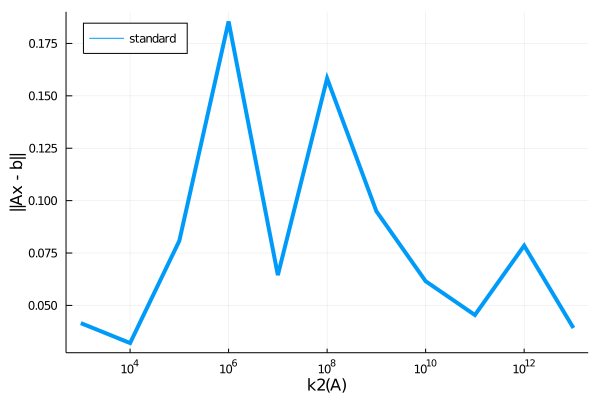

In [3]:
# Generate estimates based on A1, b1
m1 = 300
δb1 = 1e-2 * randn(m1)
A1s = [A[1:m1, :] for A in As]
b1s = [b[1:m1] + δb1 for b in bs]
x̂1s = [A1 \ b1 for (A1, b1) in zip(A1s, b1s)]
errs = [norm(A * x̂1 - b, 2) / norm(b, 2) for (x̂1, A, b) in zip(x̂1s, As, bs)]
plot(scales, errs,   lw=4,
     xlabel="k2(A)", ylabel="||Ax - b||",
     xscale=:log10, label="standard", legend=:topleft)

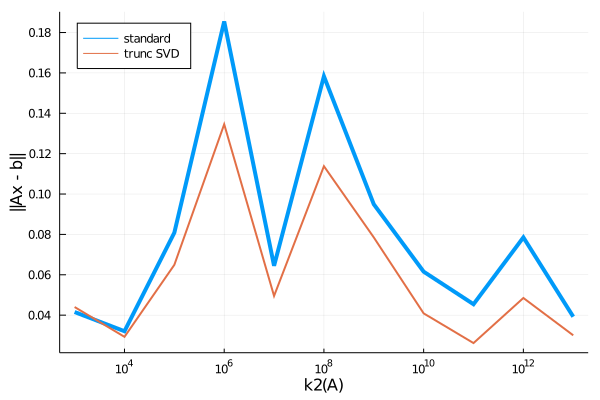

In [4]:
# Truncated SVD
function ls_svd_trunc(A::Array{Float64,2}, b::Vector{Float64}, k::Int64)
    U, Σ, V = svd(A)
    return V[:,1:k] * (Diagonal(Σ[1:k]) \ (U[:,1:k]' * b))
end

x̂_tsvds  = [ls_svd_trunc(A1, b1, 10) for (A1, b1) in zip(A1s, b1s)]
tsvd_errs = [norm(A * x̂_tsvd - b, 2) / norm(b, 2) for (x̂_tsvd, A, b) in zip(x̂_tsvds, As, bs)]
plot!(scales, tsvd_errs,  lw=2, label="trunc SVD")

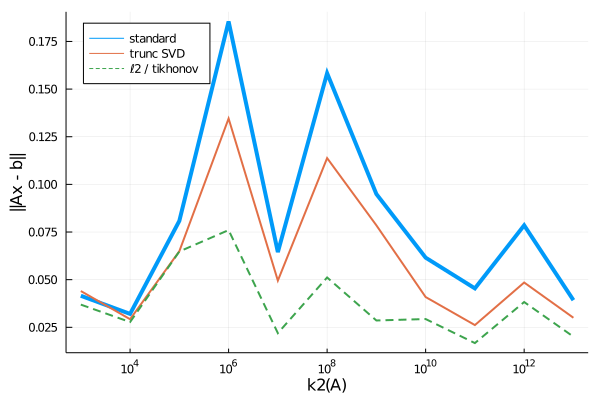

In [5]:
# Tikhonov / L2 regularization
function ls_svd_tik(A::Array{Float64,2}, b::Vector{Float64}, λ::Float64)
    U, Σ, V = svd(A)
    FΣ = Σ ./ (Σ .^ 2 .+ λ^2)
    return V * Diagonal(FΣ) * (U' * b)
end

λ = 1e-2
x̂_λs = [ls_svd_tik(A1, b1, λ) for (A1, b1) in zip(A1s, b1s)]
tik_errs = [norm(A * x̂_λ - b, 2) / norm(b, 2) for (x̂_λ, A, b) in zip(x̂_λs, As, bs)]
plot!(scales, tik_errs, lw=2, ls=:dash, label="ℓ2 / tikhonov")

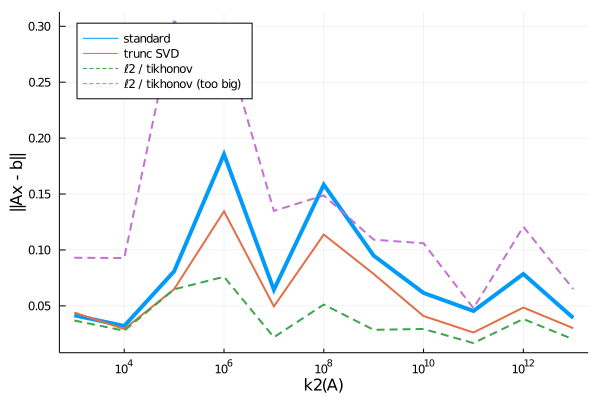

In [6]:
λ = 1e-1
x̂_λs = [ls_svd_tik(A1, b1, λ) for (A1, b1) in zip(A1s, b1s)]
tik_errs = [norm(A * x̂_λ - b, 2) / norm(b, 2) for (x̂_λ, A, b) in zip(x̂_λs, As, bs)]
plot!(scales, tik_errs, lw=2, ls=:dash, label="ℓ2 / tikhonov (too big)")